# LIT-like LOB Pipeline (FI-2010)

This notebook runs a lightweight EDA and then launches training using the project pipeline.

Before running:
- Download FI-2010 (see data/README.md)
- Update configs/lit_like.yaml with correct paths

In [18]:
import os
import sys
import warnings
from pathlib import Path

_USER_HOME = os.path.expanduser("~")
_orig_formatwarning = getattr(warnings, "_formatwarning_orig", warnings.formatwarning)

def _formatwarning(message, category, filename, lineno, line=None):
    if _USER_HOME and filename:
        filename = filename.replace(_USER_HOME, "~")
    return _orig_formatwarning(message, category, filename, lineno, line)

warnings.formatwarning = _formatwarning

project_root = Path().resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f"Project root added to sys.path: {project_root.name}")

Project root added to sys.path: Quant_project


In [19]:
from pathlib import Path
import yaml
import numpy as np

from src.data_processing import load_fi2010_file, parse_fi2010_levels, build_lit_tensor
from src.labels import estimate_tick_size, build_directional_labels

config_path = project_root / "configs" / "lit_like.yaml"
cfg = yaml.safe_load(config_path.read_text())

train_path = Path(cfg["train_path"])
if not train_path.is_absolute():
    train_path = (project_root / train_path).resolve()
if not train_path.exists():
    raise FileNotFoundError(f"Missing FI-2010 file: {train_path}. See data/README.md")
print("Config loaded.")

Config loaded.


In [20]:
x_train, _ = load_fi2010_file(str(train_path))
print("Train matrix shape:", x_train.shape)

parsed_level = parse_fi2010_levels(
    x_train,
    levels_per_side=cfg["levels_per_side"],
    order="level",
)
parsed_block = parse_fi2010_levels(
    x_train,
    levels_per_side=cfg["levels_per_side"],
    order="block",
)

def _sanity(parsed):
    ask_px0 = parsed["ask_px"][0, 0]
    bid_px0 = parsed["bid_px"][0, 0]
    spread0 = ask_px0 - bid_px0
    return float(ask_px0), float(bid_px0), float(spread0)

level_vals = _sanity(parsed_level)
block_vals = _sanity(parsed_block)
print("Order=level   (ask,bid,spread):", level_vals)
print("Order=block   (ask,bid,spread):", block_vals)
print("Choose the order where spread is small and positive.")

Train matrix shape: (47342, 40)
Order=level   (ask,bid,spread): (0.39023251, 0.37921743, 0.011015079999999955)
Order=block   (ask,bid,spread): (0.39023251, 0.46270474, -0.07247223000000003)
Choose the order where spread is small and positive.


In [21]:
parsed = parse_fi2010_levels(
    x_train,
    levels_per_side=cfg["levels_per_side"],
    order=cfg["fi2010_order"],
)
best_bid = parsed["bid_px"][:, 0]
best_ask = parsed["ask_px"][:, 0]
mid_price = (best_bid + best_ask) / 2.0
spread = best_ask - best_bid

print("Mid price stats:", float(np.mean(mid_price)), float(np.std(mid_price)))
print("Spread stats:", float(np.mean(spread)), float(np.std(spread)))

Mid price stats: -1.569959026689097e-09 0.9999562563888293
Spread stats: 3.221241179156616e-10 0.016293281321941012


In [22]:
tick_size, source = estimate_tick_size(best_bid, best_ask, mid_price)
labels = build_directional_labels(
    mid_price,
    cfg["horizons"],
    tick_size,
    neutral_band_ticks=cfg["neutral_band_ticks"],
)
h_idx = cfg["horizon_idx"]
y = labels[h_idx]
counts = np.bincount(y, minlength=3)
print("Tick size:", tick_size, "source:", source)
print("Label distribution (down/flat/up):", counts.tolist())

Tick size: 0.001014 source: best_bid_ask_mode
Label distribution (down/flat/up): [25715, 12465, 9162]


In [23]:
lit_tensor, _, _, _ = build_lit_tensor(
    x_train,
    levels_per_side=cfg["levels_per_side"],
    order=cfg["fi2010_order"],
    train_end=int(0.7 * len(x_train)),
    scalers=None,
    use_extra=cfg.get("c_in_extra", True),
)
print("LIT tensor shape (N, H, C):", lit_tensor.shape)

LIT tensor shape (N, H, C): (47342, 20, 12)


--- Price normalization ---
price_rel (raw): mean=0.0002 std=0.0105 p1/5/50/95/99=[-0.0149, -0.005, 0.0, 0.0052, 0.0198]
price_scaled: mean=0.0064 std=0.9123 p1/5/50/95/99=[-1.2902, -0.5302, -0.0025, 0.5548, 1.425]
--- Size normalization ---
size_log (raw): mean=0.1703 std=0.3664 p1/5/50/95/99=[0.0, 0.0, 0.0, 1.0162, 1.6317]
size_scaled: mean=-0.1669 std=0.8795 p1/5/50/95/99=[-0.7023, -0.6945, -0.5041, 1.8338, 3.3769]


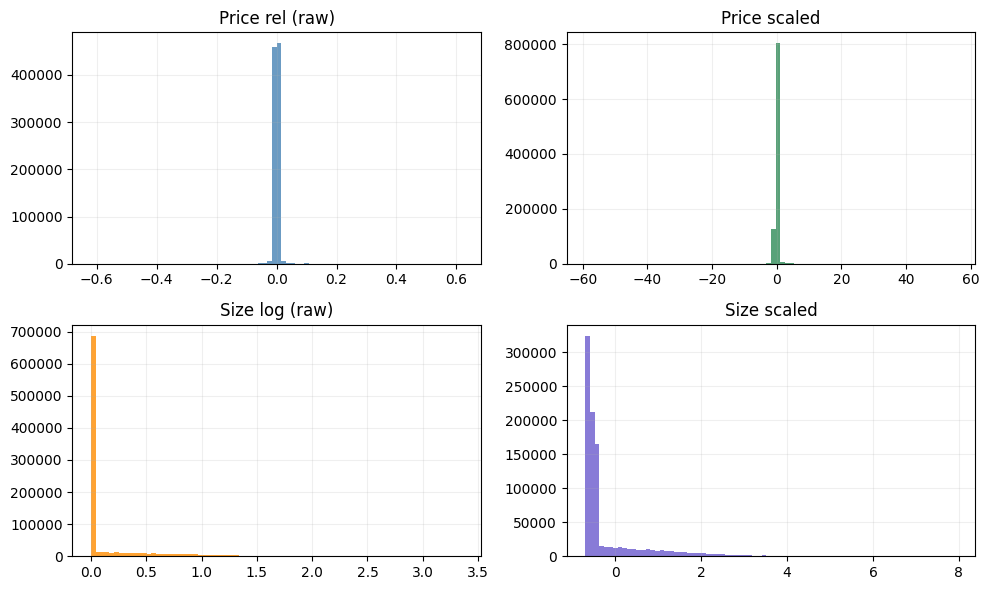

In [24]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Inspect normalization before and after scaling
parsed_norm = parse_fi2010_levels(
    x_train,
    levels_per_side=cfg["levels_per_side"],
    order=cfg["fi2010_order"],
)
ask_px = parsed_norm["ask_px"]
bid_px = parsed_norm["bid_px"]
ask_sz = parsed_norm["ask_sz"]
bid_sz = parsed_norm["bid_sz"]

mid_px = (ask_px[:, 0] + bid_px[:, 0]) / 2.0
price_raw = np.concatenate([ask_px, bid_px], axis=1).astype(np.float32)
size_raw = np.concatenate([ask_sz, bid_sz], axis=1).astype(np.float32)

eps = 1e-6
price_rel = (price_raw - mid_px[:, None]) / (mid_px[:, None] + eps)
price_rel = np.where(np.isfinite(price_rel), price_rel, 0.0)
size_log = np.log1p(np.maximum(size_raw, 0.0))
size_log = np.where(np.isfinite(size_log), size_log, 0.0)

train_end = int(0.7 * len(x_train))
price_scaler = StandardScaler().fit(price_rel[:train_end])
size_scaler = StandardScaler().fit(size_log[:train_end])
price_scaled = price_scaler.transform(price_rel)
size_scaled = size_scaler.transform(size_log)

def _summ(name, arr):
    flat = arr.reshape(-1)
    pct = np.percentile(flat, [1, 5, 50, 95, 99]).round(4).tolist()
    print(f"{name}: mean={flat.mean():.4f} std={flat.std():.4f} p1/5/50/95/99={pct}")
    return flat

print("--- Price normalization ---")
price_rel_flat = _summ("price_rel (raw)", price_rel)
price_scaled_flat = _summ("price_scaled", price_scaled)
print("--- Size normalization ---")
size_log_flat = _summ("size_log (raw)", size_log)
size_scaled_flat = _summ("size_scaled", size_scaled)

# Histograms
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].hist(price_rel_flat, bins=80, color="steelblue", alpha=0.8)
axes[0, 0].set_title("Price rel (raw)")
axes[0, 1].hist(price_scaled_flat, bins=80, color="seagreen", alpha=0.8)
axes[0, 1].set_title("Price scaled")
axes[1, 0].hist(size_log_flat, bins=80, color="darkorange", alpha=0.8)
axes[1, 0].set_title("Size log (raw)")
axes[1, 1].hist(size_scaled_flat, bins=80, color="slateblue", alpha=0.8)
axes[1, 1].set_title("Size scaled")
for ax in axes.ravel():
    ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## Training settings (read this before running)

This notebook reads training settings from configs/lit_like.yaml.
Key knobs you will iterate on:
- neutral_band_ticks (labels)
- ovr_pos_weight (down, flat, up)
- epochs and patience (quick iteration)

We log confusion matrix + per-class metrics in results/metrics/lit_like_fi2010.json.

In [25]:
import sys
import importlib

from src import train as train_module

# Run training inside the notebook so tqdm renders properly.
config_path = config_path.resolve()
_argv = sys.argv.copy()
sys.argv = [sys.argv[0], "--config", str(config_path)]
try:
    importlib.reload(train_module)
    train_module.main()
finally:
    sys.argv = _argv

~\Quant_project\src\models\lit_like.py:187: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True


Epoch 1: train_loss=0.5869 train_acc=0.6936 val_loss=0.5807 val_f1=0.5309


Epoch 2: train_loss=0.5825 train_acc=0.6936 val_loss=0.5770 val_f1=0.5787


Epoch 3: train_loss=0.5783 train_acc=0.7009 val_loss=0.5773 val_f1=0.5463


Epoch 4: train_loss=0.5720 train_acc=0.6966 val_loss=0.5665 val_f1=0.5841


Epoch 5: train_loss=0.5696 train_acc=0.6945 val_loss=0.5648 val_f1=0.5711


Saved metrics and confusion matrix.
